Data


In [2]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

len(X), len(y)

(1000, 1000)

In [3]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [4]:
#binary classification as only 0 and 1s

In [5]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})
circles[:10]

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


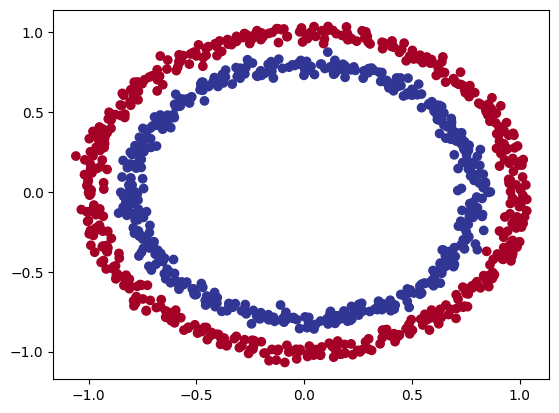

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c=y,
            cmap = 'RdYlBu');

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

data to tensors, create train test split

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

Device agnostic code

In [11]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x : torch.Tensor):
    return self.layer2(self.layer1(x))

#instantiate model class and send it to target device
model0 = CircleModelV1().to(device)
next(model0.parameters()).device

device(type='cpu')

In [13]:

model0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.0693,  0.5437],
                      [-0.0900, -0.6847],
                      [ 0.5285, -0.3775],
                      [ 0.5587,  0.5387],
                      [ 0.1346, -0.2928]])),
             ('layer1.bias',
              tensor([ 0.5211,  0.2554, -0.6123,  0.4897,  0.2463])),
             ('layer2.weight',
              tensor([[-0.0929, -0.2545,  0.3703,  0.1009, -0.3094]])),
             ('layer2.bias', tensor([0.3272]))])

Loss & Optimizer

In [14]:
loss_fn = nn.BCEWithLogitsLoss() #already integrates sigmoid function
optim = torch.optim.SGD(params=model0.parameters(), lr = 0.1)

Calculate Accuracy

In [15]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

Train Model

In [16]:
y_logits = model0(X_test.to(device))[:5]
y_logits #these are logits, layer right before it is passed to
#activation function.

tensor([[-0.0416],
        [ 0.0878],
        [-0.2487],
        [ 0.0165],
        [-0.0391]], grad_fn=<SliceBackward0>)

In [17]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs #prediction probs

tensor([[0.4896],
        [0.5219],
        [0.4381],
        [0.5041],
        [0.4902]], grad_fn=<SigmoidBackward0>)

In [19]:
y_preds = torch.round(y_pred_probs) #prediction labels
y_preds

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)

Training & Test loop


In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#loop
for epoch in range(epochs):
  model0.train()

  #forward pass
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss/accuracy
  loss = loss_fn(y_logits,
                 y_train)  #expects raw logits as input (BCEwithLogitsloss)

  acc = accuracy_fn(y_true= y_train,
                    y_pred = y_pred)

  optim.zero_grad()

  loss.backward()

  optim.step()

  #testing loop
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69587 | Acc: 49.75% | Test Loss: 0.70229 | Test Acc: 49.50%
Epoch: 10 | Loss: 0.69523 | Acc: 50.12% | Test Loss: 0.70122 | Test Acc: 48.00%
Epoch: 20 | Loss: 0.69479 | Acc: 50.25% | Test Loss: 0.70034 | Test Acc: 47.50%
Epoch: 30 | Loss: 0.69445 | Acc: 50.12% | Test Loss: 0.69959 | Test Acc: 47.50%
Epoch: 40 | Loss: 0.69419 | Acc: 50.12% | Test Loss: 0.69896 | Test Acc: 47.50%
Epoch: 50 | Loss: 0.69398 | Acc: 50.12% | Test Loss: 0.69842 | Test Acc: 47.50%
Epoch: 60 | Loss: 0.69381 | Acc: 50.25% | Test Loss: 0.69796 | Test Acc: 48.00%
Epoch: 70 | Loss: 0.69367 | Acc: 50.12% | Test Loss: 0.69756 | Test Acc: 48.00%
Epoch: 80 | Loss: 0.69356 | Acc: 50.25% | Test Loss: 0.69722 | Test Acc: 47.50%
Epoch: 90 | Loss: 0.69346 | Acc: 50.38% | Test Loss: 0.69692 | Test Acc: 47.00%


In [21]:
#model isnt learning anything?

In [22]:
#VISUALIZE VISUALIZE VISUALIZE

In [23]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

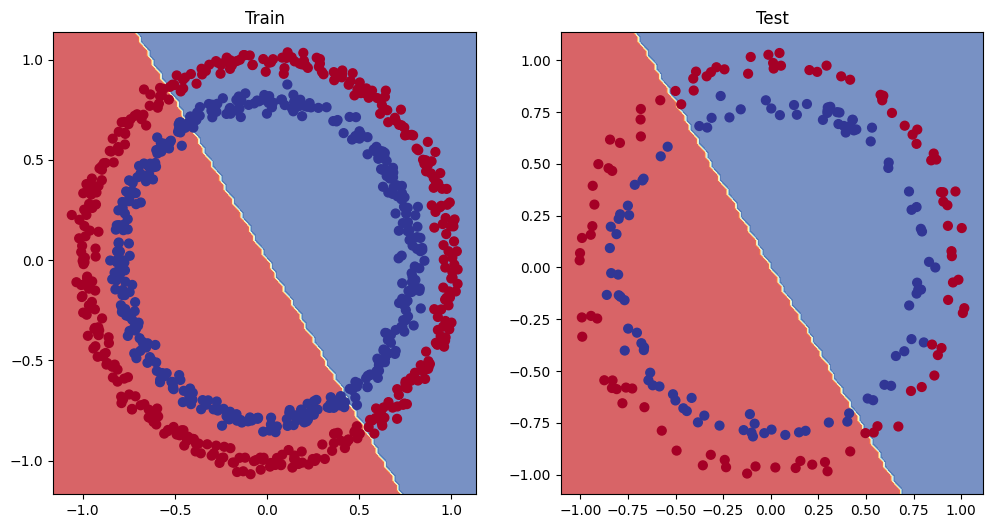

In [24]:
#Plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

Improving Model

In [25]:
#from a model perspective, rather than data q
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x : torch.Tensor):
    return self.layer3(self.layer2(self.layer1(x)))

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer =  torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#train for longer
epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model1.train()

  y_logits = model1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss & accuracy
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing loop
  model1.eval()
  with torch.inference_mode():
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    #print out whats happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc}")


Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.69261 | Test Acc: 51.0
Epoch: 100 | Loss: 0.69305 | Acc: 50.38% | Test Loss: 0.69379 | Test Acc: 48.0
Epoch: 200 | Loss: 0.69299 | Acc: 51.12% | Test Loss: 0.69437 | Test Acc: 46.0
Epoch: 300 | Loss: 0.69298 | Acc: 51.62% | Test Loss: 0.69458 | Test Acc: 45.0
Epoch: 400 | Loss: 0.69298 | Acc: 51.12% | Test Loss: 0.69465 | Test Acc: 46.0
Epoch: 500 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69467 | Test Acc: 46.0
Epoch: 600 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.0
Epoch: 700 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.0
Epoch: 800 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.0
Epoch: 900 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.0


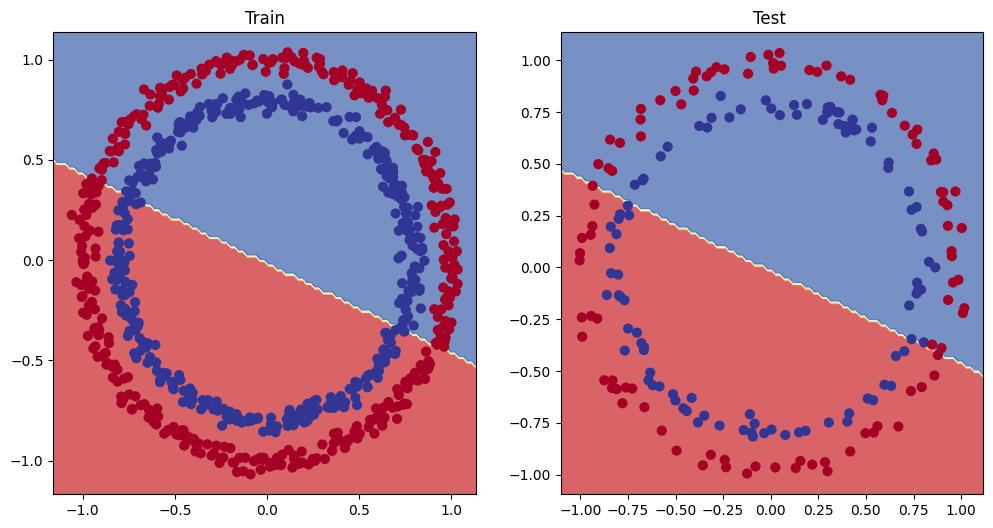

In [28]:
#Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test ")
plot_decision_boundary(model1, X_test, y_test)


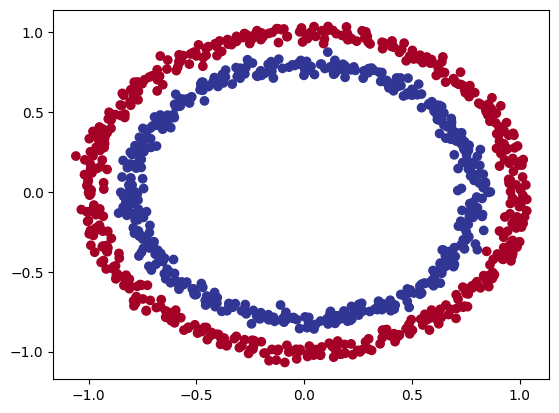

In [29]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap=plt.cm.RdYlBu)

In [30]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

Building a Model with Non-Linearity

In [31]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=20)
    self.layer2 = nn.Linear(in_features=20, out_features=20)
    self.layer3 = nn.Linear(in_features=20, out_features=1)
    self.relu = nn.ReLU() #non-linear activation

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model2 = CircleModelV2().to(device)
model2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [32]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

Training

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model2.train()

  y_logits = model2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing
  model2.eval()
  with torch.inference_mode():
    test_logits = model2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69448 | Acc: 47.62% | Test Loss: 0.69197 | Test Acc: 54.00%
Epoch: 100 | Loss: 0.69102 | Acc: 53.12% | Test Loss: 0.68961 | Test Acc: 56.50%
Epoch: 200 | Loss: 0.68750 | Acc: 56.88% | Test Loss: 0.68704 | Test Acc: 57.00%
Epoch: 300 | Loss: 0.68379 | Acc: 59.62% | Test Loss: 0.68357 | Test Acc: 59.50%
Epoch: 400 | Loss: 0.67821 | Acc: 63.12% | Test Loss: 0.67807 | Test Acc: 63.00%
Epoch: 500 | Loss: 0.66898 | Acc: 69.50% | Test Loss: 0.66913 | Test Acc: 72.00%
Epoch: 600 | Loss: 0.65292 | Acc: 75.38% | Test Loss: 0.65433 | Test Acc: 77.00%
Epoch: 700 | Loss: 0.62314 | Acc: 85.62% | Test Loss: 0.62753 | Test Acc: 84.00%
Epoch: 800 | Loss: 0.56539 | Acc: 94.62% | Test Loss: 0.57623 | Test Acc: 94.00%
Epoch: 900 | Loss: 0.45988 | Acc: 99.38% | Test Loss: 0.48168 | Test Acc: 98.00%


Evaluation of this non linear code

In [34]:
model2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

Plot decision boundary

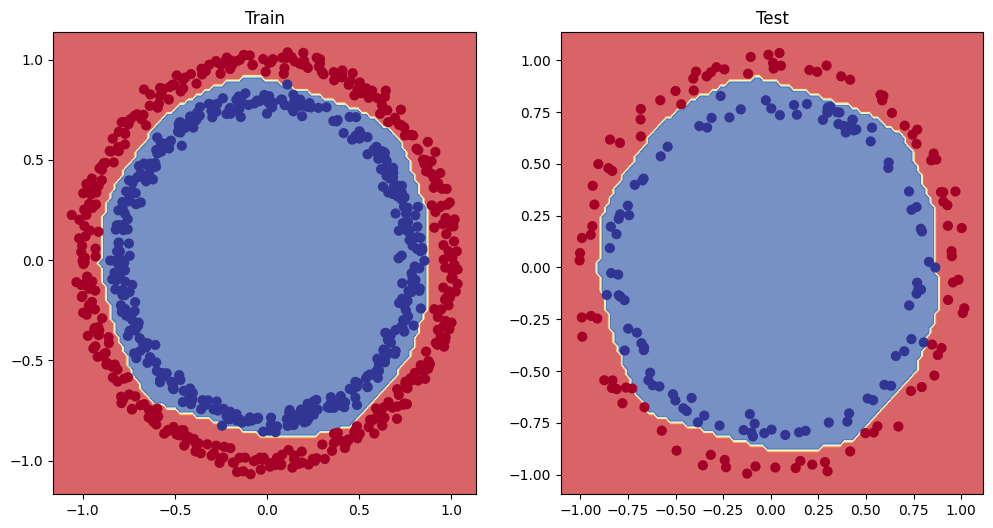

In [35]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)

Replicating non-linear activation functions

In [36]:
A = torch.arange(-10, 10, 1, dtype = torch.float32)

In [37]:
#Visualize

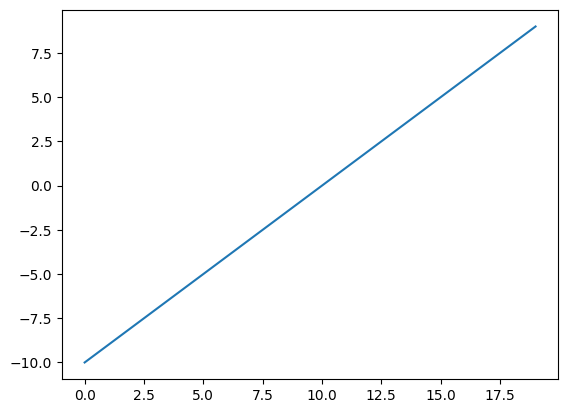

In [38]:
plt.plot(A)

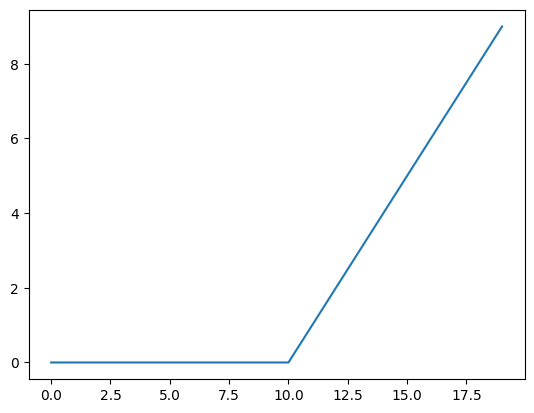

In [39]:
plt.plot(torch.relu(A))

In [40]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

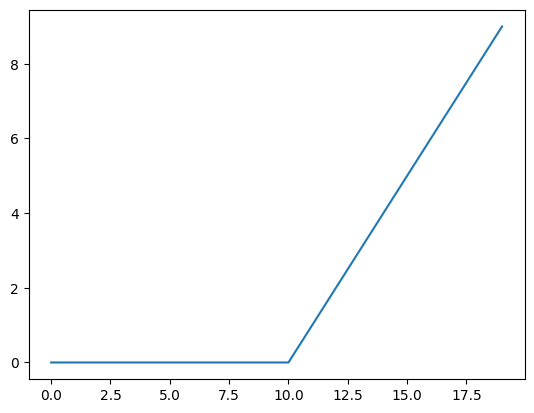

In [41]:
plt.plot(relu(A))

In [42]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

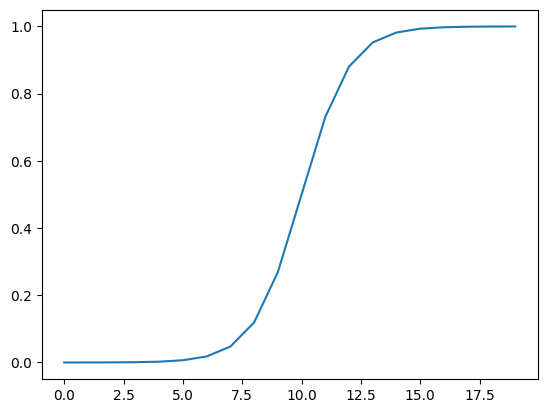

In [43]:
plt.plot(sigmoid(A))

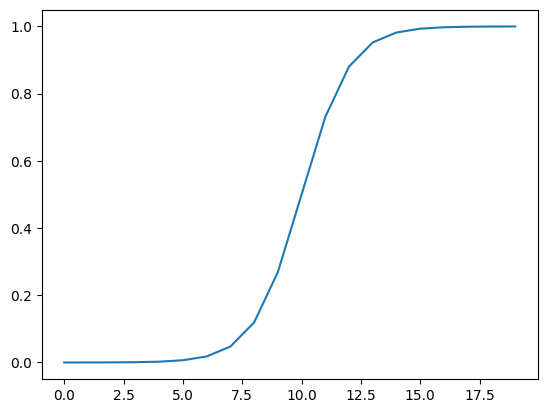

In [44]:
plt.plot(torch.sigmoid(A))

Putting it all together for MULTI-CLASS Classification

In [45]:
#creating toy multiclass dataset

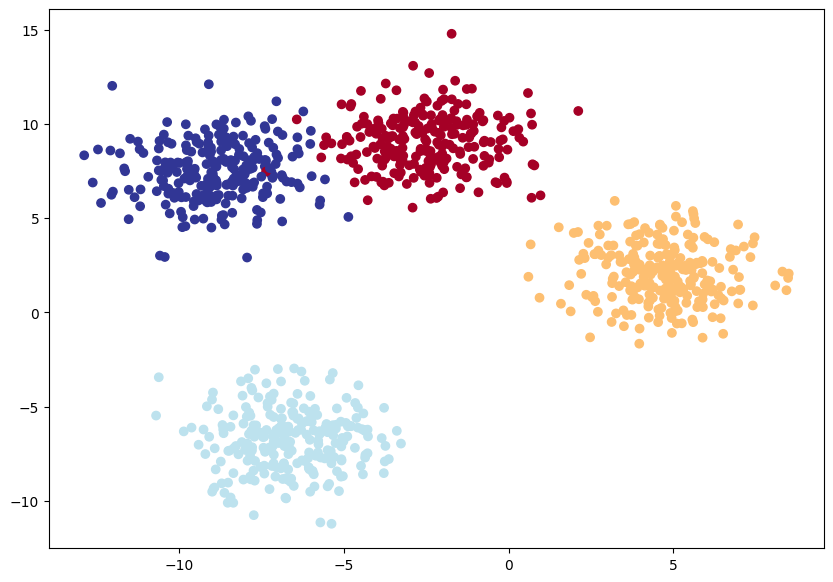

In [69]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42 #all caps because hyperparameters

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std=1.5,
                            random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.FloatTensor)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

#Plot

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

Building a multiclass classification model in PyTorch

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [71]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x:torch.Tensor):
    return self.linear_layer_stack(x)

model3 = BlobModel(input_features=2,
                   output_features=4).to(device)
model3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model3.parameters(), lr=0.1)


In [73]:
#raw outputs of model
model3.eval()
with torch.inference_mode():
  y_logits = model3(X_blob_test.to(device))

y_logits[:10] #these are raw logits
#we have to convert these into probabilities

tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950],
        [-0.3673, -0.0935,  0.5180, -0.5787],
        [-0.3457,  0.2076,  0.1297, -0.9071],
        [ 0.1158, -0.1460,  0.1752, -0.1939],
        [-0.4845,  0.2289,  0.1336, -1.1274],
        [ 0.1284, -0.1145,  0.1691, -0.1944]])

In [74]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)
y_preds[:10], y_logits.argmax(dim=1)[:10]

(tensor([1, 2, 1, 1, 2, 2, 1, 2, 1, 2]),
 tensor([1, 2, 1, 1, 2, 2, 1, 2, 1, 2]))

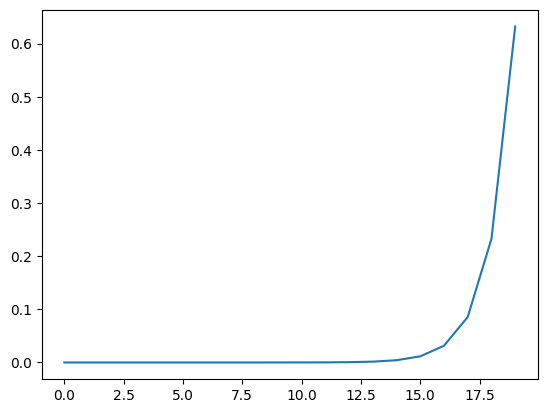

In [75]:
plt.plot(torch.softmax(A, dim=0))

In [76]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model3.train()

  y_logits = model3(X_blob_train).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing
  model3.eval()
  with torch.inference_mode():
    test_logits = model3(X_blob_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.32603 | Acc: 33.00% | Test Loss: 1.16789 | Test Acc: 50.50%
Epoch: 10 | Loss: 0.56130 | Acc: 77.50% | Test Loss: 0.51789 | Test Acc: 76.50%
Epoch: 20 | Loss: 0.37431 | Acc: 81.12% | Test Loss: 0.36443 | Test Acc: 82.00%
Epoch: 30 | Loss: 0.27698 | Acc: 94.00% | Test Loss: 0.25921 | Test Acc: 97.50%
Epoch: 40 | Loss: 0.14797 | Acc: 98.62% | Test Loss: 0.13505 | Test Acc: 100.00%
Epoch: 50 | Loss: 0.09577 | Acc: 99.00% | Test Loss: 0.08503 | Test Acc: 99.50%
Epoch: 60 | Loss: 0.07167 | Acc: 99.00% | Test Loss: 0.06172 | Test Acc: 99.50%
Epoch: 70 | Loss: 0.05855 | Acc: 99.12% | Test Loss: 0.04892 | Test Acc: 99.50%
Epoch: 80 | Loss: 0.05049 | Acc: 99.12% | Test Loss: 0.04102 | Test Acc: 99.50%
Epoch: 90 | Loss: 0.04512 | Acc: 99.12% | Test Loss: 0.03573 | Test Acc: 99.50%


Visualize

In [77]:
model3.eval()
with torch.inference_mode():
  y_logits = model3(X_blob_test).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

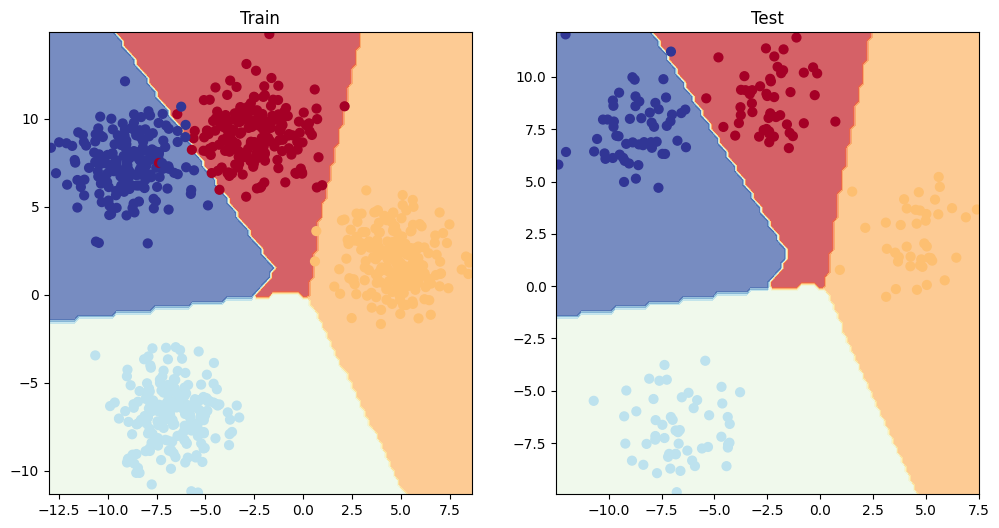

In [78]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model3, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model3, X_blob_test, y_blob_test)